In [1]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from single_photons.simulation.simulation_particle import simulation_p
import single_photons.utils.constants as ct
from single_photons.environment import Particle
from single_photons.utils.parameters import *
from control import dare


In [2]:
omega = 2*np.pi*1e5
T = 2*np.pi/omega
t = np.arange(0, 1000*T, T/400)
N = t.shape[0]
p = 0
radius = 75e-9
wavelength = 1.064e-6
power = 300e-3
waist = 0.6e-6
eta_detection = 1
delta_t = 1e-9
control_step = 30 
fs = 1/(control_step*delta_t)
gamma, omega, ba_force, std_detection, std_z = compute_parameters_simulation(power, wavelength, waist, 
                                                                      radius, p, fs, eta_detection)
coupling = (1/(4*np.pi))*(ba_force**2)
env = Particle(omega, gamma, coupling, eta_detection=eta_detection)
variance_process = env.thermal_force_std**2 + env.backaction_std**2
std_detection = std_detection/env.zp_x
period = 2*np.pi/omega
t = np.arange(0, 5 * period, delta_t)
N = t.shape[0]

In [3]:
Q = np.array([[0, 0], [0, variance_process]])*control_step*delta_t/2
R = np.array([[np.power(std_detection,2)]])

In [4]:
g_fb = 2*omega
Ad = scipy.linalg.expm(env.A *control_step*delta_t)
Bd = env.B * delta_t * control_step
cost_states = np.array([[omega/2, 0],
                        [0, omega/2]])
X, L, G_fb = dare(Ad, Bd, cost_states, omega/(g_fb**2))

In [5]:
x0 = 0
P0 = 10
new_states, measured_states, estimated_states, cov_aposteriori, controls = simulation_p(
    env.A,
    env.B, 
    env.thermal_force_std,
    env.backaction_std, 
    std_detection, 
    eta_detection,
    x0, 
    P0, 
    Ad, 
    Bd, 
    env.C, 
    env.G,
    G_fb,
    Q, 
    R, 
    delta_t, 
    control_step, 
    N
)

/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/single_photons-0.0.1-py3.8.egg/single_photons/simulation/simulation_particle.py:57: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/single_photons-0.0.1-py3.8.egg/single_photons/simulation/simulation_particle.py:57: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))


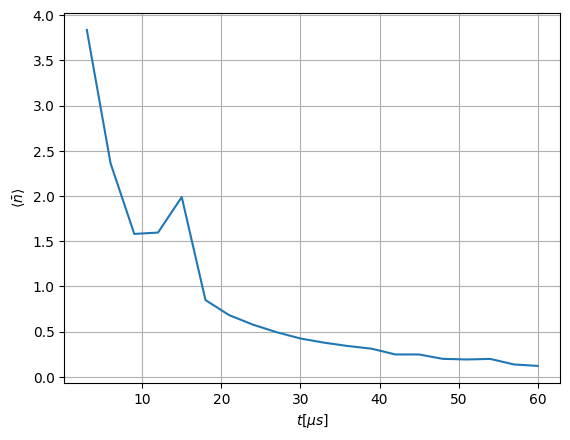

In [6]:
step=100
phonons = compute_phonons(estimated_states[::control_step, :], cov_aposteriori, step=step)
plt.plot(t[::control_step][::step][1:]/1e-6, phonons)
#plt.xlim([t[::control_step][::step][1]/1e-6, t[::control_step][::step][-1]/1e-6])
#plt.ylim([0,20])
plt.ylabel(r'$\langle \bar{n} \rangle$')
plt.xlabel(r'$t[\mu s]$')
plt.grid()
#plt.ylim([0,3])
plt.show()

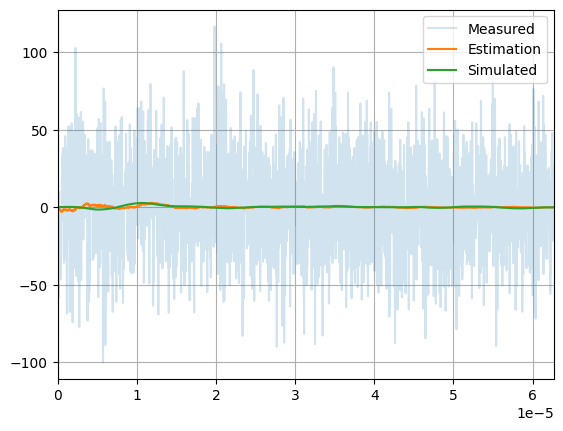

In [7]:
plt.plot(t[:], measured_states[:], alpha=0.2)
plt.plot(t[:], estimated_states[:,0])
plt.plot(t[:], new_states[:,0])
#plt.ylim([-10, 10])
plt.xlim([t[0], t.max()])
#plt.title(r'$\lange n \rangle = $')
plt.legend(['Measured', 'Estimation', 'Simulated'])
plt.grid()

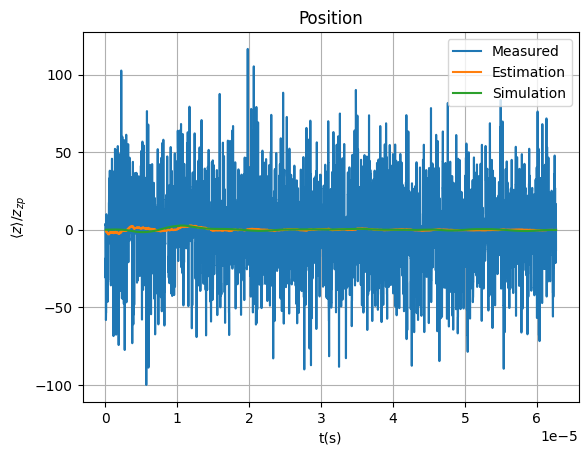

In [8]:
fig = plt.Figure()
plt.title('Position')
plt.plot(t, measured_states)
plt.plot(t[100:], estimated_states[100:,0])
plt.plot(t[100:], new_states[100:,0])
plt.legend(['Measured', 'Estimation', 'Simulation'], loc='upper right')
plt.xlabel(r't(s)')
plt.ylabel(r'$\langle z\rangle/z_{zp}$')
plt.grid()
plt.show()

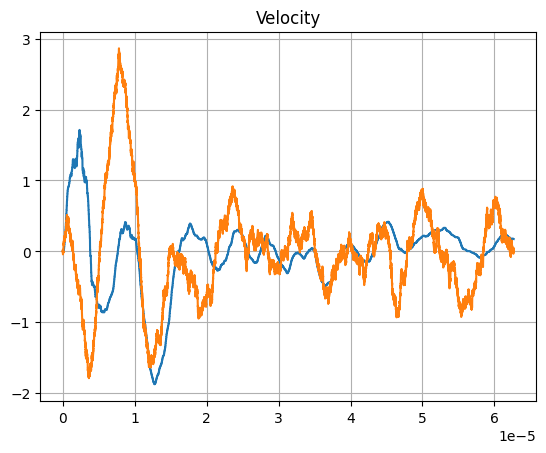

In [9]:
fig = plt.Figure()
plt.title('Velocity')
plt.plot(t[:], estimated_states[:,1])
plt.plot(t[:], new_states[:,1])
plt.grid()
plt.show()

In [11]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [12]:
df = pd.DataFrame()
df['z'] = butter_bandpass_filter(estimated_states[:,0][::30], 22e3, 220e3, 1/(30e-9), order=2)[500:]
df['p'] = butter_bandpass_filter(estimated_states[:,1][::30], 22e3, 220e3, 1/(30e-9), order=2)[500:]

(-0.024667118549369666, 0.6559741419785707)

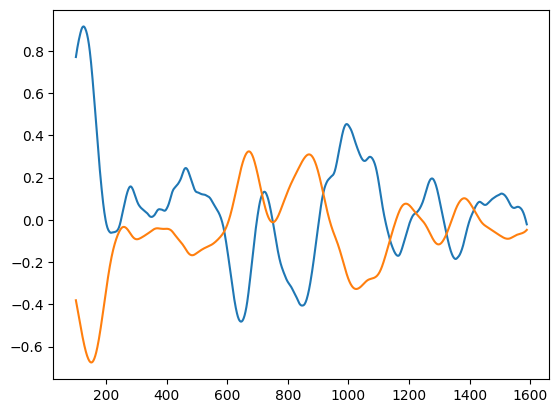

In [13]:
plt.plot(df['z'][100:])
plt.plot(df['p'][100:])
df['z'].values[0], df['p'].values[0]

OptionError: "No such keys(s): 'mode.use_inf_as_null'"

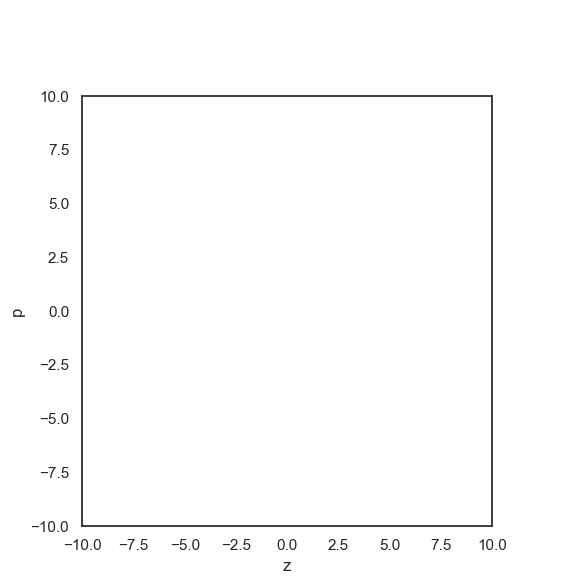

In [14]:
sns.set_theme(style="white")
g = sns.JointGrid(data=df, x="z", y="p", space=0, xlim=[-10,10], ylim=[-10,10])
g.plot_joint(sns.lineplot, sort = False)#clip=((2200, 6800), (10, 25)),
             #thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.kdeplot, alpha=1, fill=True)
g.set_axis_labels(r'$z/z_{zp}$',r'$p/p_{zp}$')

In [83]:
(1/np.sqrt(delta_t))*1.76*np.sqrt(4e-28)/env.zp_x

213.99399630660082

In [47]:
cov_mat = kalman.error_covariance_aposteriori[-1]
z_std = env.zp_x*np.sqrt(cov_mat[0,0])
p_std = env.zp_p*np.sqrt(cov_mat[1,1])
np.sqrt(cov_mat)

matrix([[0.98349965, 0.48859526],
        [0.48859526, 1.0453487 ]])

In [48]:
estimated_states[-30:].var(axis=0)

array([0.00109741, 0.00011264])

In [49]:
(env._m_*np.power(env.__omega__, 2)*np.power(z_std,2)+np.power(p_std,2)/env._m_)/(2*ct.hbar*env.__omega__)

0.5150063676876289

In [50]:
z_std*p_std > ct.hbar/2

True

In [54]:
print(kalman.error_covariance_apriori[-1],std_detection)

[[0.97447875 0.24050408]
 [0.24050408 1.09319291]] 11.436084942324618
